In [1]:
cd /home/azindancioglu15/Research/StyleGAN_latent_space/stylegan-encoder


/home/azindancioglu15/Research/StyleGAN_latent_space/stylegan-encoder


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config_ = tf.ConfigProto()
config_.gpu_options.allow_growth = True
session = InteractiveSession(config=config_)

In [5]:

print(tf.__version__)

import os 
import config 
import dnnlib
import gzip
import json 
import numpy as np 
#from tqdm import tqdm_notebook 
import warnings
import matplotlib.pylab as plt
%matplotlib inline
warnings.filterwarnings('ignore')

import PIL.Image
from PIL import ImageFilter
import cv2

import sys
sys.path.append("../Github_code")

from clustering_utils import FactorCatalog, MultiResolutionStore
from edit_functions import get_layer_activations, get_directions, edit_w_directions
from img_utils import mask_img, load_img, load_mask
from models import Stylegan, EditorModel

import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Embedding, Flatten
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

1.15.0


Using TensorFlow backend.


In [6]:
tf.test.is_gpu_available()

True

In [7]:
import dnnlib, pickle
import dnnlib.tflib as tflib

tflib.init_tf()

from encoder.generator_model import Generator 
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_path='/content/drive/My Drive/XAI Research/StyleGAN_latent_space/stylegan-encoder/karras2019stylegan-ffhq-1024x1024.pkl'
print('Loading StyleGAN model from %s...' %model_path)

with open('karras2019stylegan-ffhq-1024x1024.pkl', 'rb') as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)

print('StyleGAN loaded & ready for sampling')

Gs=averaged_generator_network.components.synthesis





Loading StyleGAN model from /content/drive/My Drive/XAI Research/StyleGAN_latent_space/stylegan-encoder/karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling


In [8]:

my_catalog = pickle.load(open('cluster_catalog.p', 'rb'))#load cluster catalog

"""
path_align='aligned_images'
latents='latent_representations'
latent_dirs=sorted(os.listdir(latents))
mask_path='masks'
"""

path_align='aligned_images_test3'
latents='latent_representations_test3'
latent_dirs=sorted(os.listdir(latents))
mask_path='masks_test3'
im_id = 2

W_a=np.load(os.path.join(latents, latent_dirs[im_id]))[np.newaxis,:]



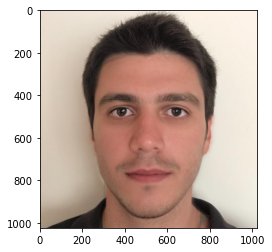

In [9]:
im = Gs.run(W_a.reshape((1,18,512)), randomize_noise =False, **synthesis_kwargs)
plt.imshow(mask_img(im_id,im[0], latent_dirs, path_align, mask_path))

In [10]:
activ = get_layer_activations(W_a[0], Gs)

In [11]:
m_combined=load_model('models/rafd_b_cfee_seperate_multilayer7')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [12]:
dirs = get_directions(m_combined)

In [13]:
#stylegan = Stylegan(Gs)

In [14]:
editor = EditorModel()

In [15]:
g_editor = editor.global_editor(m_combined)

In [16]:
l_editor = editor.local_editor(Gs)

In [17]:
edit_dict={4:0.2,8:0.1,9:0.1, 5:0.1, 1:0.1}
w_edit =edit_w_directions(edit_dict, W_a[0], dirs)
l_editor.layers[1].set_weights([w_edit.reshape((-1,18*512))])
y_mask = l_editor.predict(np.arange(1))

In [18]:
AU_names=['AU01_Inner_Brow_Raiser', 'AU02_Outer_Brow_Raiser', 'AU04_Brow_Lowerer', 'AU05_Upper_Lid_Raiser', 'AU06_Cheek_Raiser', 'AU07_Lid_Tightener', 'AU09_Nose_Wrinkler', 'AU10_Upper_Lip_Raiser', 'AU12_Lip_Corner_Puller', 'AU14_Dimpler', 'AU15_Lip_Corner_Depressor', 'AU17_Chin_Raiser', 'AU20_Lip_Stretcher', 'AU23_Lip_Tightener', 'AU25_Lip_Part', 'AU26_Jaw_Drop' ]
for item in edit_dict:
    print(AU_names[item])

AU06_Cheek_Raiser
AU12_Lip_Corner_Puller
AU14_Dimpler
AU07_Lid_Tightener
AU02_Outer_Brow_Raiser


In [19]:
for i, au in enumerate(AU_names):
  print(i, au)

0 AU01_Inner_Brow_Raiser
1 AU02_Outer_Brow_Raiser
2 AU04_Brow_Lowerer
3 AU05_Upper_Lid_Raiser
4 AU06_Cheek_Raiser
5 AU07_Lid_Tightener
6 AU09_Nose_Wrinkler
7 AU10_Upper_Lip_Raiser
8 AU12_Lip_Corner_Puller
9 AU14_Dimpler
10 AU15_Lip_Corner_Depressor
11 AU17_Chin_Raiser
12 AU20_Lip_Stretcher
13 AU23_Lip_Tightener
14 AU25_Lip_Part
15 AU26_Jaw_Drop


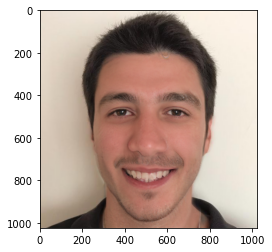

In [20]:

plt.imshow(mask_img(im_id,tflib.tfutil.convert_images_to_uint8(y_mask[0].transpose((1,2,0))).eval(), latent_dirs, path_align, mask_path))

In [21]:
activ_target = get_layer_activations(w_edit, Gs)
h_edit = my_catalog.predict(activ_target, raw = True)
h_edit_1024 = h_edit._resize(1024)

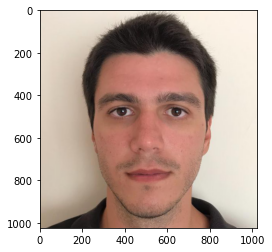

In [22]:

y_edit = plt.imread(os.path.join(path_align, latent_dirs[im_id][:-3]+'png'))
plt.imshow(y_edit)
y_edit=y_edit.transpose((2,0,1))[np.newaxis,:]

In [23]:
au_local_list=[[14,15,25], [13,14,15,17,25], [14,15,25], [15], [1,15,21,27,29], [15], [10,21],[8,21], [1,8,11, 21,23,24,29],[1,8,11,21,23,24],[1,8,11,21,23,24],[8,11,24,23],[1,8,11,21,23,24],[1,8,11,21,23,24], [7,8,11,21,24], [7,8,11,21,24],[]]


In [24]:
y_edit_mask = load_mask(im_id, latent_dirs, mask_path)

In [26]:
l_editor

In [61]:
from optimize import LocalOptimizer

In [62]:
local_opt = LocalOptimizer(l_editor, w_edit, y_edit,y_mask, y_edit_mask, h_edit_1024, edit_dict)

In [63]:
local_opt.set_masks()


In [64]:
local_opt.losses()

In [65]:
local_opt.optimize(200)

In [66]:
w_result = local_opt.get_result()

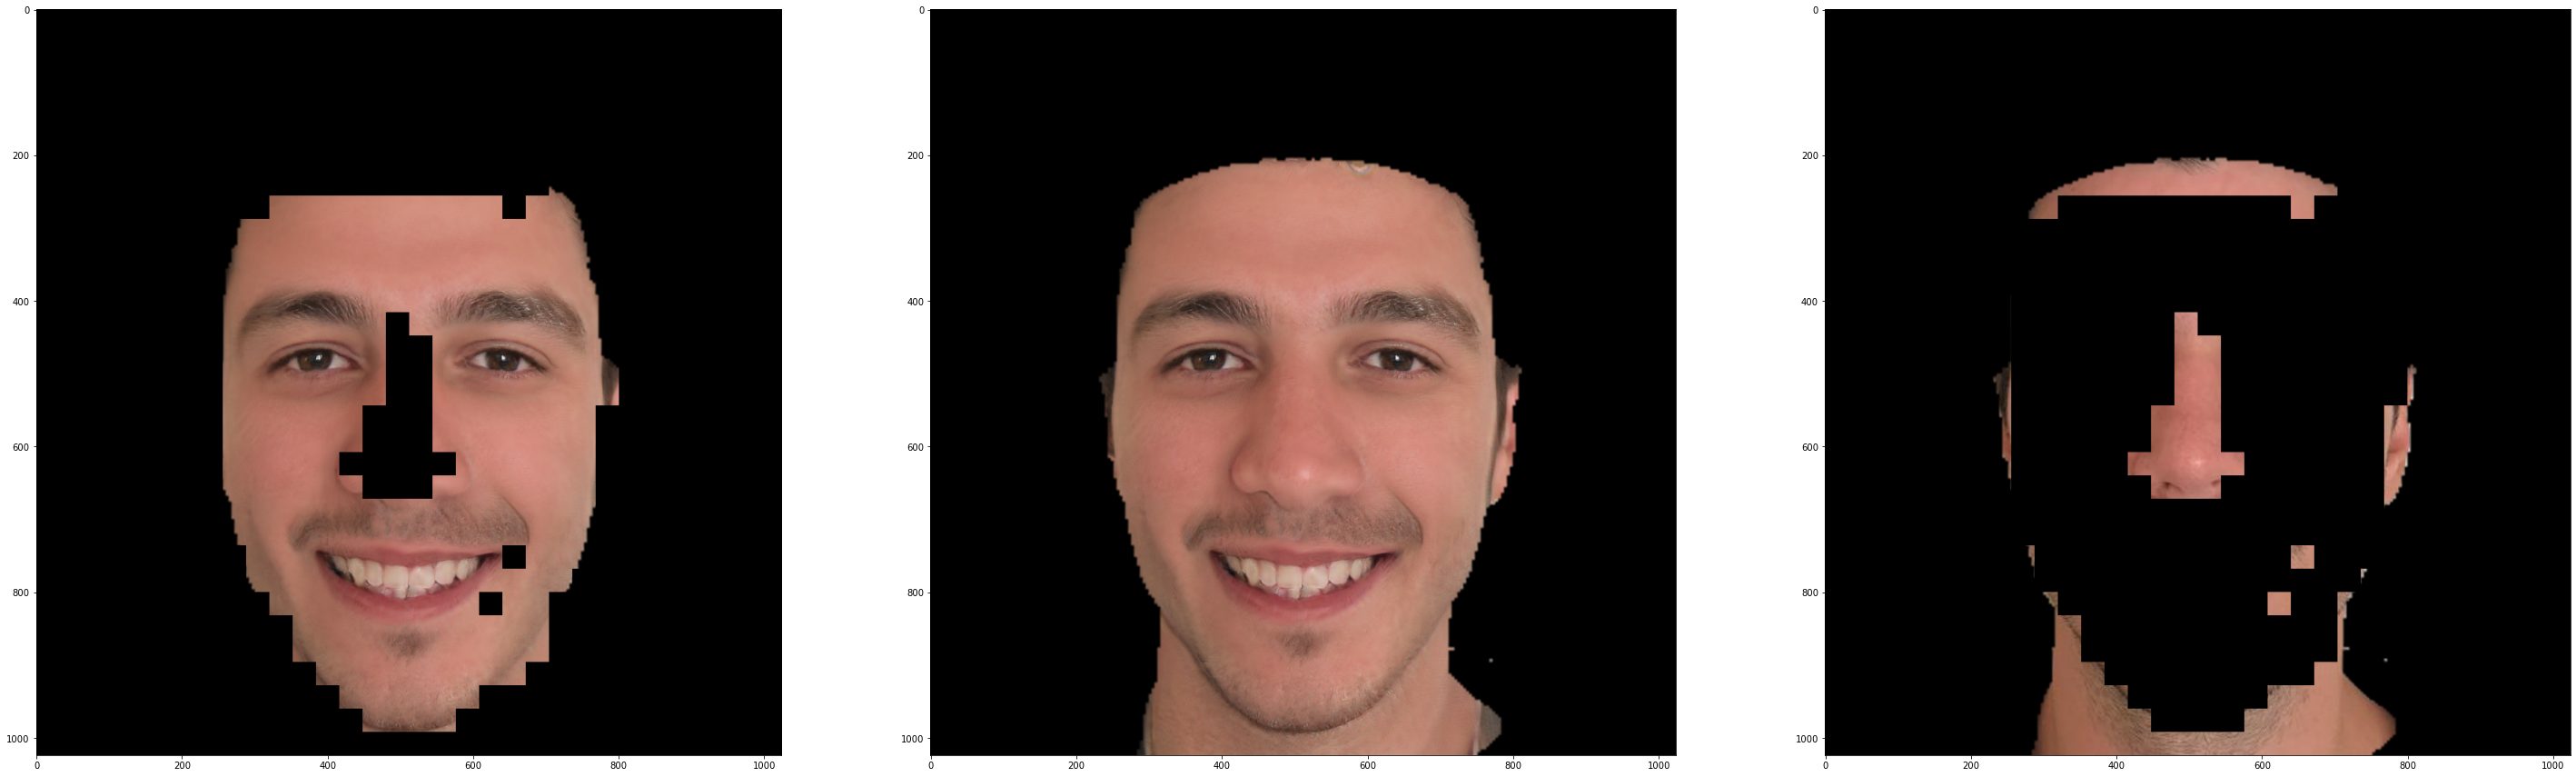

In [68]:
local_opt.plot_masks()

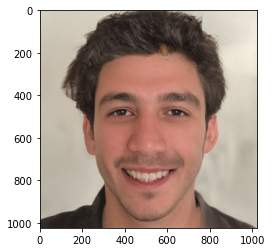

In [67]:
#w_result = l_editor.layers[1].get_weights()[0]
w_final = W_a[0].copy()
w_final[3:8] = w_result.reshape((18,512))[3:8]
im = Gs.run(w_final.reshape((1,18,512)), randomize_noise =False, **synthesis_kwargs)
plt.imshow(im[0])

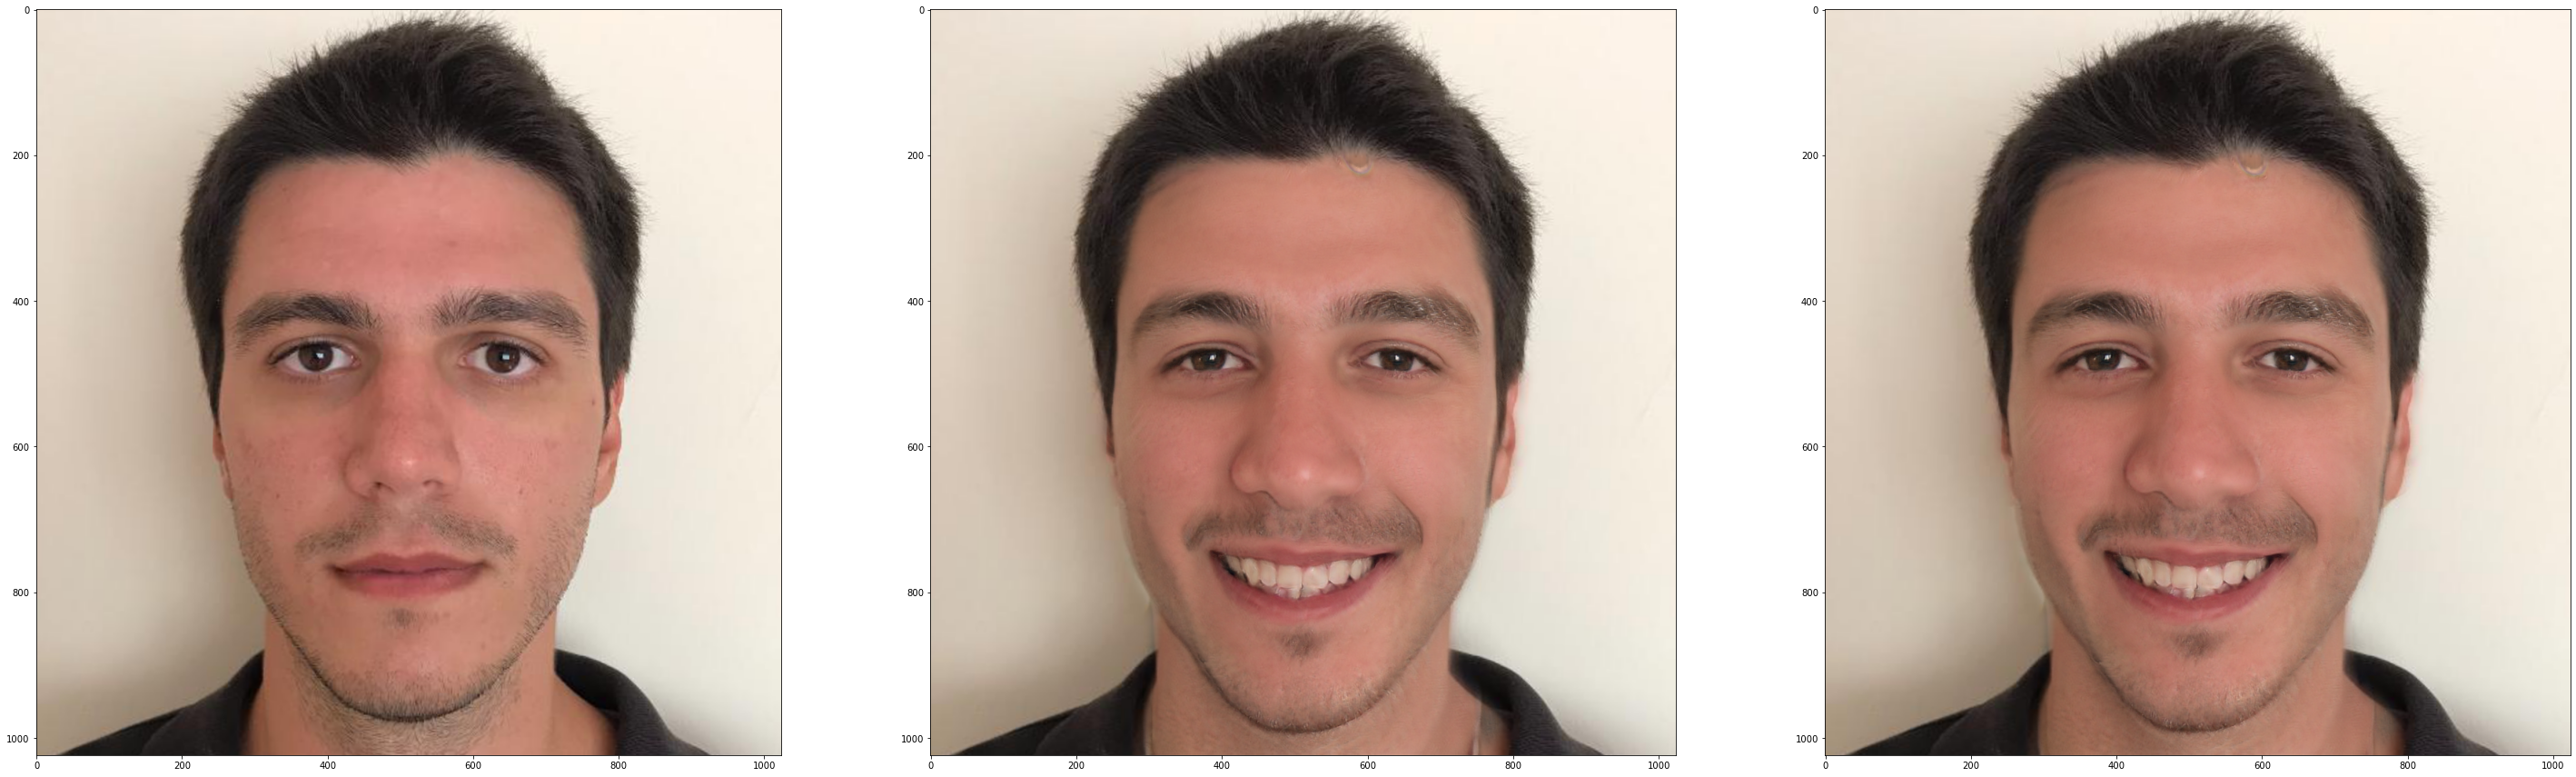

In [119]:
f, axarr = plt.subplots(1,3,figsize = (50,100))
axarr[0].imshow(y_edit[0].transpose((1,2,0)))
axarr[1].imshow(mask_img(im_id, tflib.tfutil.convert_images_to_uint8(y_mask[0].transpose((1,2,0))).eval(), latent_dirs, path_align, mask_path))
axarr[2].imshow(mask_img(im_id, im[0], latent_dirs, path_align, mask_path))
plt.show()